In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-03 02:02:12.928807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 02:02:13.003635: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 02:02:13.538697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_117


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:29<00:00,  1.03it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
926,21.070280,21.889490,4.451904,-20.794807,0.027129,0.014742,0.037067,477.5,0.0,68877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235,3
927,-2.156629,17.598087,3.993946,-21.465599,0.091583,0.079287,0.072814,597.5,0.0,68997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259,3
928,6.870979,16.874817,4.571238,-17.906569,0.048471,0.023354,0.085562,717.5,0.0,69117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22283,3
929,11.430203,8.910088,3.756421,-5.006313,0.029496,0.013204,0.031394,837.5,0.0,69237.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22307,3
930,10.291650,2.129946,1.981583,-21.022831,0.003008,0.001954,0.058677,957.5,0.0,69357.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22331,3


(494843, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 0.953821	valid_0's l2: 0.909774
[200]	valid_0's rmse: 0.858676	valid_0's l2: 0.737324
[300]	valid_0's rmse: 0.836508	valid_0's l2: 0.699745
[400]	valid_0's rmse: 0.830416	valid_0's l2: 0.689591
[500]	valid_0's rmse: 0.827641	valid_0's l2: 0.68499
[600]	valid_0's rmse: 0.826564	valid_0's l2: 0.683208
[700]	valid_0's rmse: 0.825988	valid_0's l2: 0.682256
[800]	valid_0's rmse: 0.825526	valid_0's l2: 0.681493
[900]	valid_0's rmse: 0.825142	valid_0's l2: 0.680859
[1000]	valid_0's rmse: 0.824745	valid_0's l2: 0.680204
[1100]	valid_0's rmse: 0.824485	valid_0's l2: 0.679776
[1200]	valid_0's rmse: 0.824306	valid_0's l2: 0.679481
[1300]	valid_0's rmse: 0.824162	valid_0's l2: 0.679243
[1400]	valid_0's rmse: 0.82404	valid_0's l2: 0.679042


 20%|██        | 1/5 [03:11<12:47, 191.77s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.02436	valid_0's l2: 1.04931
[200]	valid_0's rmse: 0.928837	valid_0's l2: 0.862738
[300]	valid_0's rmse: 0.906652	valid_0's l2: 0.822019
[400]	valid_0's rmse: 0.899513	valid_0's l2: 0.809124
[500]	valid_0's rmse: 0.896203	valid_0's l2: 0.803179
[600]	valid_0's rmse: 0.894687	valid_0's l2: 0.800465
[700]	valid_0's rmse: 0.893855	valid_0's l2: 0.798977
[800]	valid_0's rmse: 0.893178	valid_0's l2: 0.797767
[900]	valid_0's rmse: 0.892627	valid_0's l2: 0.796783
[1000]	valid_0's rmse: 0.892256	valid_0's l2: 0.79612
[1100]	valid_0's rmse: 0.891792	valid_0's l2: 0.795294
[1200]	valid_0's rmse: 0.89145	valid_0's l2: 0.794684
[1300]	valid_0's rmse: 0.891163	valid_0's l2: 0.794172
[1400]	valid_0's rmse: 0.890871	valid_0's l2: 0.793651
[1500]	valid_0's rmse: 0.890612	valid_0's l2: 0.79319
[1600]	valid_0's rmse: 0.890452	valid_0's l2: 0.792905
[1700]	valid_0's rmse: 0.890343	valid_0's l2: 0.79271
[1800]	valid_0's rmse: 0.890246	valid_0's l2: 0.792538
[1900]	valid

 40%|████      | 2/5 [07:01<10:41, 213.87s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.02165	valid_0's l2: 1.04376
[200]	valid_0's rmse: 0.933645	valid_0's l2: 0.871693
[300]	valid_0's rmse: 0.912131	valid_0's l2: 0.831983
[400]	valid_0's rmse: 0.904729	valid_0's l2: 0.818534
[500]	valid_0's rmse: 0.901931	valid_0's l2: 0.813479
[600]	valid_0's rmse: 0.901121	valid_0's l2: 0.812018
[700]	valid_0's rmse: 0.900572	valid_0's l2: 0.811031
[800]	valid_0's rmse: 0.900176	valid_0's l2: 0.810318
[900]	valid_0's rmse: 0.899983	valid_0's l2: 0.809969
[1000]	valid_0's rmse: 0.899608	valid_0's l2: 0.809294
[1100]	valid_0's rmse: 0.899572	valid_0's l2: 0.809229
[1200]	valid_0's rmse: 0.899481	valid_0's l2: 0.809065
[1300]	valid_0's rmse: 0.899411	valid_0's l2: 0.808939


 60%|██████    | 3/5 [09:44<06:21, 190.81s/it]

== fold 3 ==
[100]	valid_0's rmse: 0.965971	valid_0's l2: 0.9331
[200]	valid_0's rmse: 0.870728	valid_0's l2: 0.758168
[300]	valid_0's rmse: 0.848733	valid_0's l2: 0.720348
[400]	valid_0's rmse: 0.844029	valid_0's l2: 0.712385
[500]	valid_0's rmse: 0.841715	valid_0's l2: 0.708484
[600]	valid_0's rmse: 0.840789	valid_0's l2: 0.706926
[700]	valid_0's rmse: 0.840204	valid_0's l2: 0.705944
[800]	valid_0's rmse: 0.839872	valid_0's l2: 0.705385
[900]	valid_0's rmse: 0.839621	valid_0's l2: 0.704964
[1000]	valid_0's rmse: 0.839405	valid_0's l2: 0.7046
[1100]	valid_0's rmse: 0.839306	valid_0's l2: 0.704435
[1200]	valid_0's rmse: 0.83899	valid_0's l2: 0.703903
[1300]	valid_0's rmse: 0.839074	valid_0's l2: 0.704045


 80%|████████  | 4/5 [12:23<02:58, 178.29s/it]

== fold 4 ==
[100]	valid_0's rmse: 0.967728	valid_0's l2: 0.936497
[200]	valid_0's rmse: 0.880353	valid_0's l2: 0.775021
[300]	valid_0's rmse: 0.860811	valid_0's l2: 0.740996
[400]	valid_0's rmse: 0.855166	valid_0's l2: 0.731309
[500]	valid_0's rmse: 0.853033	valid_0's l2: 0.727665
[600]	valid_0's rmse: 0.851689	valid_0's l2: 0.725373
[700]	valid_0's rmse: 0.850825	valid_0's l2: 0.723904
[800]	valid_0's rmse: 0.850462	valid_0's l2: 0.723286
[900]	valid_0's rmse: 0.850122	valid_0's l2: 0.722707
[1000]	valid_0's rmse: 0.850017	valid_0's l2: 0.722528
[1100]	valid_0's rmse: 0.849995	valid_0's l2: 0.722491
[1200]	valid_0's rmse: 0.849851	valid_0's l2: 0.722247


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 0.945344	valid_0's l2: 0.893676
[200]	valid_0's rmse: 0.846683	valid_0's l2: 0.716872
[300]	valid_0's rmse: 0.823681	valid_0's l2: 0.678451
[400]	valid_0's rmse: 0.816678	valid_0's l2: 0.666964
[500]	valid_0's rmse: 0.814312	valid_0's l2: 0.663104
[600]	valid_0's rmse: 0.81344	valid_0's l2: 0.661685
[700]	valid_0's rmse: 0.813229	valid_0's l2: 0.661342
[800]	valid_0's rmse: 0.812999	valid_0's l2: 0.660968


 20%|██        | 1/5 [01:58<07:54, 118.75s/it]

== fold 1 ==
[100]	valid_0's rmse: 0.992306	valid_0's l2: 0.984672
[200]	valid_0's rmse: 0.884759	valid_0's l2: 0.782799
[300]	valid_0's rmse: 0.857912	valid_0's l2: 0.736013
[400]	valid_0's rmse: 0.847512	valid_0's l2: 0.718277
[500]	valid_0's rmse: 0.843329	valid_0's l2: 0.711204
[600]	valid_0's rmse: 0.841798	valid_0's l2: 0.708623
[700]	valid_0's rmse: 0.841362	valid_0's l2: 0.70789
[800]	valid_0's rmse: 0.840688	valid_0's l2: 0.706756
[900]	valid_0's rmse: 0.84022	valid_0's l2: 0.705969
[1000]	valid_0's rmse: 0.840129	valid_0's l2: 0.705816
[1100]	valid_0's rmse: 0.839771	valid_0's l2: 0.705216
[1200]	valid_0's rmse: 0.83943	valid_0's l2: 0.704643
[1300]	valid_0's rmse: 0.839234	valid_0's l2: 0.704313
[1400]	valid_0's rmse: 0.839101	valid_0's l2: 0.70409
[1500]	valid_0's rmse: 0.838975	valid_0's l2: 0.703878
[1600]	valid_0's rmse: 0.838887	valid_0's l2: 0.703731
[1700]	valid_0's rmse: 0.838774	valid_0's l2: 0.703542
[1800]	valid_0's rmse: 0.838787	valid_0's l2: 0.703564
[1900]	val

 40%|████      | 2/5 [05:39<08:56, 178.70s/it]

== fold 2 ==
[100]	valid_0's rmse: 0.994806	valid_0's l2: 0.98964
[200]	valid_0's rmse: 0.898662	valid_0's l2: 0.807594
[300]	valid_0's rmse: 0.874745	valid_0's l2: 0.76518
[400]	valid_0's rmse: 0.867285	valid_0's l2: 0.752183
[500]	valid_0's rmse: 0.864788	valid_0's l2: 0.747858
[600]	valid_0's rmse: 0.863712	valid_0's l2: 0.745998
[700]	valid_0's rmse: 0.863131	valid_0's l2: 0.744996
[800]	valid_0's rmse: 0.862702	valid_0's l2: 0.744256
[900]	valid_0's rmse: 0.862575	valid_0's l2: 0.744036


 60%|██████    | 3/5 [08:00<05:23, 161.59s/it]

== fold 3 ==
[100]	valid_0's rmse: 0.978347	valid_0's l2: 0.957164
[200]	valid_0's rmse: 0.898416	valid_0's l2: 0.807152
[300]	valid_0's rmse: 0.882986	valid_0's l2: 0.779664
[400]	valid_0's rmse: 0.879228	valid_0's l2: 0.773042
[500]	valid_0's rmse: 0.877908	valid_0's l2: 0.770723
[600]	valid_0's rmse: 0.877501	valid_0's l2: 0.770008
[700]	valid_0's rmse: 0.87704	valid_0's l2: 0.7692
[800]	valid_0's rmse: 0.876809	valid_0's l2: 0.768794
[900]	valid_0's rmse: 0.8766	valid_0's l2: 0.768427
[1000]	valid_0's rmse: 0.876615	valid_0's l2: 0.768453


 80%|████████  | 4/5 [10:17<02:31, 151.68s/it]

== fold 4 ==
[100]	valid_0's rmse: 0.972169	valid_0's l2: 0.945113
[200]	valid_0's rmse: 0.886079	valid_0's l2: 0.785135
[300]	valid_0's rmse: 0.867412	valid_0's l2: 0.752403
[400]	valid_0's rmse: 0.861683	valid_0's l2: 0.742497
[500]	valid_0's rmse: 0.859573	valid_0's l2: 0.738866
[600]	valid_0's rmse: 0.858721	valid_0's l2: 0.737401
[700]	valid_0's rmse: 0.858259	valid_0's l2: 0.736608
[800]	valid_0's rmse: 0.857965	valid_0's l2: 0.736105
[900]	valid_0's rmse: 0.857641	valid_0's l2: 0.735547
[1000]	valid_0's rmse: 0.857555	valid_0's l2: 0.7354
[1100]	valid_0's rmse: 0.857493	valid_0's l2: 0.735295
[1200]	valid_0's rmse: 0.857403	valid_0's l2: 0.735139
[1300]	valid_0's rmse: 0.857254	valid_0's l2: 0.734885
[1400]	valid_0's rmse: 0.857243	valid_0's l2: 0.734865


100%|██████████| 5/5 [13:01<00:00, 156.27s/it]


## Dynamic-Range NMS

<AxesSubplot: >

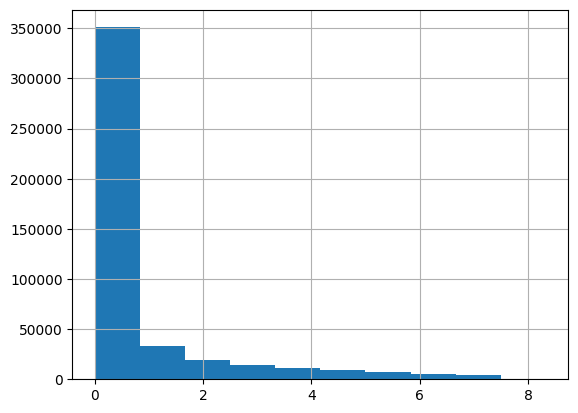

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:07<00:00, 39.37it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7831


event   tolerance
onset   12           0.265584
        36           0.683226
        60           0.779602
        90           0.826249
        120          0.846644
        150          0.863596
        180          0.874068
        240          0.889241
        300          0.894927
        360          0.899833
wakeup  12           0.226525
        36           0.699517
        60           0.783603
        90           0.826248
        120          0.849456
        150          0.865043
        180          0.877675
        240          0.893335
        300          0.903621
        360          0.913649
dtype: float64